In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta, timezone
import yfinance as yf 
from scipy.optimize import minimize 
import seaborn as sns
from scipy import stats


In [18]:
Seans_Tickers = [

    'NLR', 'URA','RSP','VOO','QQQ','BMO'

]
end_date = datetime.now()
start_date = end_date - timedelta(days = 2 * 365)
print (start_date)
print (end_date)


2023-06-14 20:43:07.302522
2025-06-13 20:43:07.302522


In [19]:
df = yf.download(Seans_Tickers, start=start_date, end=end_date)

/var/folders/1r/jlk6s6nd0ss3h022myjjhb6w0000gn/T/ipykernel_57383/1623270481.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(Seans_Tickers, start=start_date, end=end_date)
[*********************100%***********************]  5 of 5 completed


make a subset by the close and valumne columns 

In [20]:
df = df.loc[:, ['Close', 'Volume']]
df = df.sort_index()

creating a multi level column sutrcture for ROR 

In [21]:
pct = df['Close'].pct_change()

pct.columns = pd.MultiIndex.from_product([['RoR'], pct.columns])

Concatenating the new RoR DataFrame with the original 

In [22]:
df1 = pd.concat([df, pct], axis=1)
df1.dropna(inplace=True)
print(df1)

                 Close                                                 Volume  \
Ticker             NLR         QQQ         RSP        URA         VOO     NLR   
Date                                                                            
2023-06-16   57.494461  363.267273  144.006699  20.684040  393.912994    3100   
2023-06-20   57.076942  362.747284  142.696747  20.555624  392.095306    3000   
2023-06-21   56.896648  357.803833  142.492706  20.463900  389.947113    3900   
2023-06-22   56.004673  362.025543  141.909592  20.051138  391.366241    3500   
2023-06-23   55.122185  358.436615  140.685165  19.546648  388.430725    2200   
...                ...         ...         ...        ...         ...     ...   
2025-06-09  101.949997  530.700012  178.720001  35.180000  551.250000  662900   
2025-06-10   99.339996  534.210022  179.610001  34.049999  554.390015  569200   
2025-06-11  105.150002  532.409973  179.100006  35.869999  552.859985  631400   
2025-06-12  105.279999  533.

Lets look at Calculating Cumulatlive Returns 
1st)calculate total returns for each stock 
2nd)Plot returns 

Ticker           NLR       QQQ       RSP       URA       VOO
Date                                                        
2023-06-16  1.000000  1.000000  1.000000  1.000000  1.000000
2023-06-20  0.992738  0.998569  0.990904  0.993792  0.995386
2023-06-21  0.989602  0.984960  0.989487  0.989357  0.989932
2023-06-22  0.974088  0.996582  0.985437  0.969401  0.993535
2023-06-23  0.958739  0.986702  0.976935  0.945011  0.986083
...              ...       ...       ...       ...       ...
2025-06-09  1.773214  1.460908  1.241053  1.700828  1.399421
2025-06-10  1.727819  1.470570  1.247234  1.646197  1.407392
2025-06-11  1.828872  1.465615  1.243692  1.734187  1.403508
2025-06-12  1.831133  1.469056  1.246609  1.740956  1.408814
2025-06-13  1.826785  1.450612  1.231540  1.746757  1.393125

[500 rows x 5 columns]


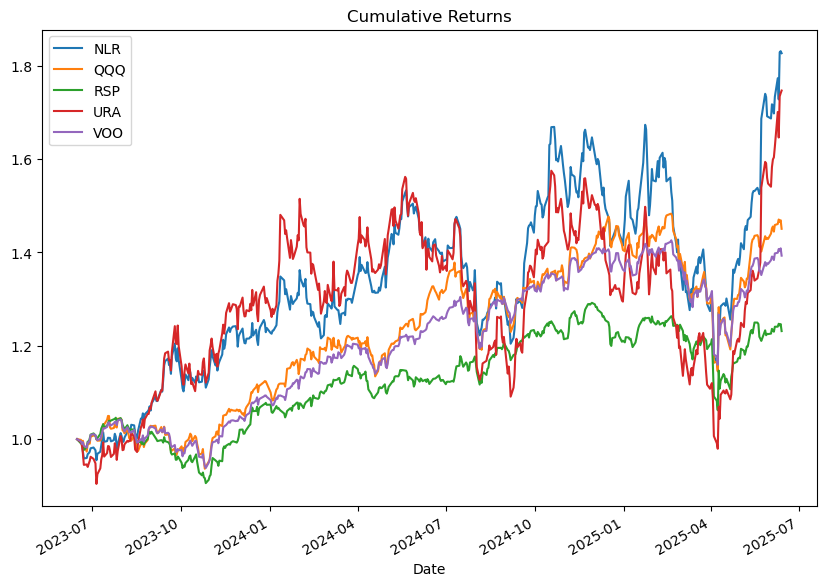

In [23]:
cum_returns = (df1['Close'] / df1['Close'].iloc[0])
print(cum_returns)
cum_returns.plot(figsize=(10, 7))
plt.title('Cumulative Returns')
plt.legend(loc='upper left')
plt.show()

Calculate the mean, std deviation and mean/std deviation ratio annualized (252 TRADING DAYS IN A YEAR)

In [24]:
RoR = df1['RoR'] 

In [25]:
mean_vals = RoR.mean() * 252
std_vals = RoR.std() * np.sqrt(252)
ratio_vals = mean_vals / std_vals


Create a figure and a set of subplots (2 plots)

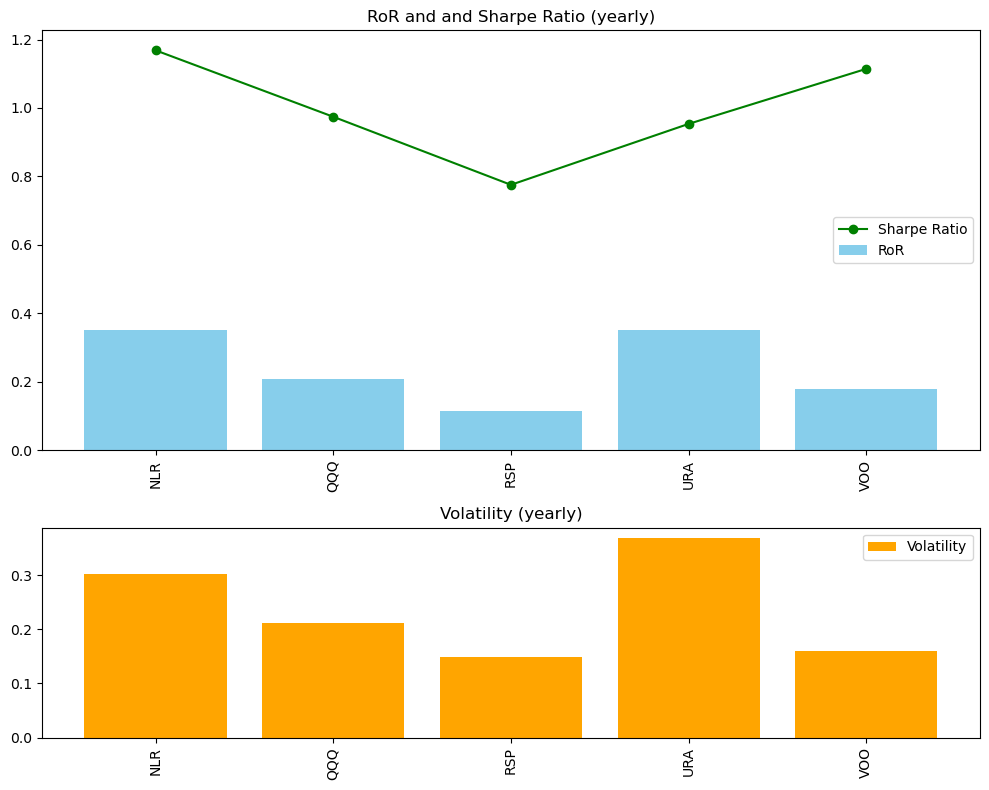

In [26]:
RoR = df1['RoR']
# Calculate the mean, std, and mean/std ratio (yearly)
mean_vals = RoR.mean() * 252
std_vals = RoR.std() * np.sqrt(252)
ratio_vals = mean_vals / std_vals
# Create a figure and a set of subplots (2 plots)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8),
                               gridspec_kw={'height_ratios':
                                            [2, 1]})
# Plotting mean values as a bar plot in the first subplot
ax1.set_title('RoR and and Sharpe Ratio (yearly)')
ax1.bar(mean_vals.index, mean_vals, color='skyblue', label='RoR')
# Plotting mean/std ratio as a line plot on the same axes
ax1.plot(ratio_vals.index, ratio_vals, color='green',
         marker='o', linestyle='-', label='Sharpe Ratio')
# Rotate x-axis labels for the first subplot
ax1.tick_params(axis='x', rotation=90)
ax1.legend()
# Plotting std values as a bar plot in the second subplot
ax2.set_title('Volatility (yearly)')
ax2.bar(std_vals.index, std_vals,
        color='orange', label='Volatility')
# Rotate x-axis labels for the second subplot
ax2.tick_params(axis='x', rotation=90)
ax2.legend()
# Adjusting layout and showing the plot
plt.tight_layout()
plt.show()


The following code is to assess the core financial metrics related to the following asssets (asset proportions are based on randum number generation) 

In [27]:
def calculate_portfolio_metrics (df, w):
    # Calculate the log returns 
    log_RoR = (df/df.shift(1)).apply(np.log).dropna()
    # Calculate the portfolio return
    portfolio_return = np.sum(log_RoR.mean() * w) * 252
    #calculate the std devation of the portfolio(two ways to do it)
    
    sd1 = (log_RoR*w).sum(axis=1).std() * np.sqrt(252)
    sd2 = np.sqrt(np.dot(w.T, np.dot(log_RoR.cov() * 252, w)))


    # Calculate the Sharpe ratio
    sharpe_ratio = portfolio_return / sd2
    
    return (portfolio_return, sd1,sd2, sharpe_ratio)
#########################################################################################
w = np.random.random(len(df1['Close'].columns))
w /= np.sum(w)
addition_of_weights = sum(w)
print(f"addition_of_weights: {addition_of_weights}")
print(f"Initial Weights: {w}")
pm = calculate_portfolio_metrics(df1['Close'], w)
print("Optimization")

print(f"Portfolio Return: {pm[0]:.2f}")
print(f"Portfolio Volatility: {pm[1]:.2f}")
print(f"Sharpe Ratio: {pm[2]:.2f}") 





 


addition_of_weights: 0.9999999999999999
Initial Weights: [0.11681545 0.08058775 0.13277879 0.57859203 0.09122598]
Optimization
Portfolio Return: 0.24
Portfolio Volatility: 0.27
Sharpe Ratio: 0.27


Monte carlo 2000 simulations

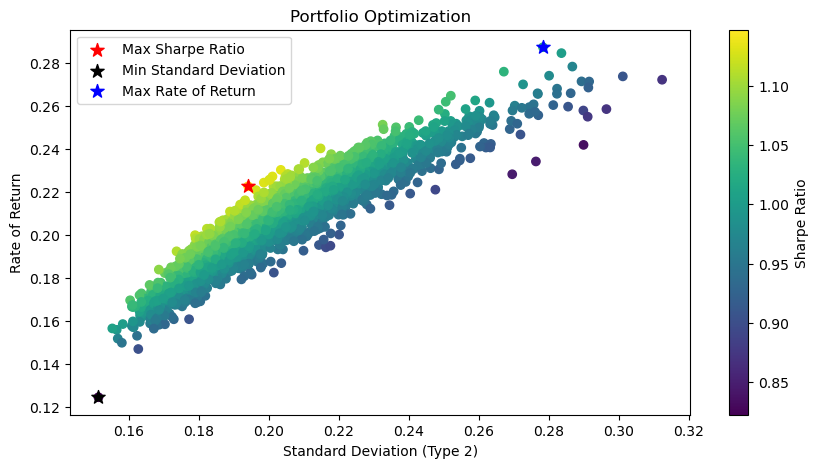

In [28]:
# Number of simulations to run
simulation_numbers = 2000
# Define the tickers for the portfolio
portfolio_tickers = ['NLR', 'URA', 'RSP', 'VOO', 'QQQ']
# Generate random weights for all simulations
weights = np.random.random((simulation_numbers,
                            len(portfolio_tickers)))
weights /= weights.sum(axis=1)[:, np.newaxis]
# Initialize arrays to store the results of the simulations
RoR_arr = np.zeros(simulation_numbers) 
sd1_arr = np.zeros(simulation_numbers)
sd2_arr = np.zeros(simulation_numbers)
sharpe_arr = np.zeros(simulation_numbers)
# Run simulations to calculate portfolio metrics
for i in range(simulation_numbers):
    # Current set of weights
    w = weights[i] 
    # Calculate portfolio metrics for the current weights
    portfolio_assets = df['Close'][portfolio_tickers]
    m = calculate_portfolio_metrics(portfolio_assets, w)
    RoR_arr[i], sd1_arr[i], sd2_arr[i], sharpe_arr[i] = \
        m[0], m[1], m[2], m[3]
# Create a DataFrame to store the simulation results
portfolio_results = pd.DataFrame({
    'Weights': list(weights),
    'Rate of Return': RoR_arr,
    'Standard Deviation (Type 1)': sd1_arr,
    'Standard Deviation (Type 2)': sd2_arr,
    'Sharpe Ratio': sharpe_arr
})
# Scatter plot of the simulation results
plt.figure(figsize=(10, 5))
plt.scatter(portfolio_results['Standard Deviation (Type 2)'],
            portfolio_results['Rate of Return'],
            c=portfolio_results['Sharpe Ratio'],
            cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation (Type 2)')
plt.ylabel('Rate of Return')
# Find the key points of the portfolios
# Index of the portfolio with the max Sharpe Ratio
max_sharpe_idx = portfolio_results['Sharpe Ratio'].idxmax()  
# Index of the portfolio with the min Standard Deviation
min_std_idx = portfolio_results['Standard Deviation (Type 2)'].idxmin()  
# Index of the portfolio with the max Rate of Return
max_ror_idx = portfolio_results['Rate of Return'].idxmax()
# Highlight key points in the scatter plot
plt.scatter(portfolio_results.loc[max_sharpe_idx,
                                  'Standard Deviation (Type 2)'],
            portfolio_results.loc[max_sharpe_idx, 'Rate of Return'],
            color='red', marker='*', s=100,
            label='Max Sharpe Ratio')
plt.scatter(portfolio_results.loc[min_std_idx,
                                  'Standard Deviation (Type 2)'],
            portfolio_results.loc[min_std_idx, 'Rate of Return'],
            color='black', marker='*', s=100,
            label='Min Standard Deviation')
plt.scatter(portfolio_results.loc[max_ror_idx,
                                  'Standard Deviation (Type 2)'],
            portfolio_results.loc[max_ror_idx,
                                  'Rate of Return'],
            color='blue', marker='*', s=100,
            label='Max Rate of Return')
plt.legend()
plt.title('Portfolio Optimization')
plt.show()


Scipy minimiazation functions, analyze and compare 

In [29]:
#function to calculate portfolio returns 
def portfolio_return(weirghts, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

#function to calculate portfolio volatility
def portfolio_volatility(weights, log_returns):
    return np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))



/var/folders/1r/jlk6s6nd0ss3h022myjjhb6w0000gn/T/ipykernel_57383/633577042.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  reg_data = yf.download('NLR', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price             Close      High       Low      Open    Volume
Ticker              NLR       NLR       NLR       NLR       NLR
Price  Ticker                                                  
Close  NLR     1.000000  0.997470  0.997314  0.992827  0.592874
High   NLR     0.997470  1.000000  0.996798  0.996836  0.607023
Low    NLR     0.997314  0.996798  1.000000  0.996722  0.574309
Open   NLR     0.992827  0.996836  0.996722  1.000000  0.592670
Volume NLR     0.592874  0.607023  0.574309  0.592670  1.000000


/Users/sean/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sean/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sean/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sean/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

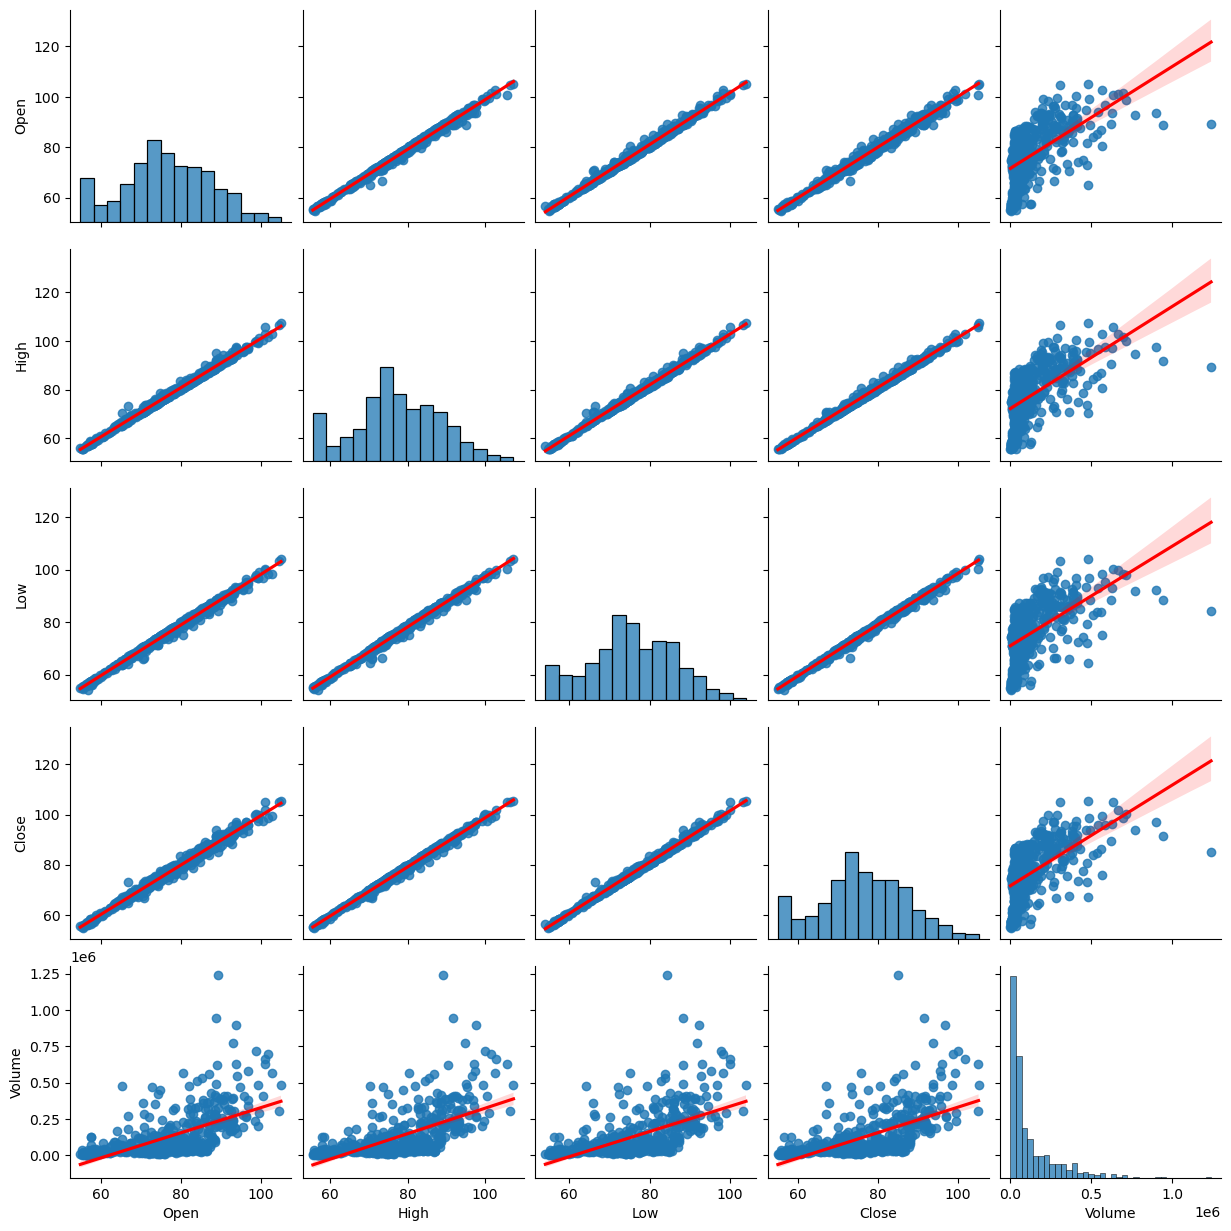

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 6.939e+04
Date:                Fri, 13 Jun 2025   Prob (F-statistic):               0.00
Time:                        20:43:17   Log-Likelihood:                -311.65
No. Observations:                 501   AIC:                             633.3
Df Residuals:                     496   BIC:                             654.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0217      0.171      0.127      0.8

In [30]:
import statsmodels.api as sm
reg_data = yf.download('NLR', start=start_date, end=end_date)
##Calculate correlation matrix 
corr_matrix = reg_data.corr()
print(corr_matrix)
### pairplot with regresssion lines 
sns.pairplot(reg_data.xs('NLR', level='Ticker', axis=1)[['Open', 'High', 'Low', 'Close', 'Volume']],
             kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()

##define the dependent and independent variables
X = reg_data.xs('NLR', level='Ticker', axis=1)[['Open', 'High', 'Low', 'Volume']]
y = reg_data.xs('NLR', level='Ticker', axis=1)['Close']
##add constant to the independent variables
X = sm.add_constant(X) ## the sm is the statsmodels library and we are adding a constant to the independent variables
### create an ols model
model = sm.OLS(y, X).fit()
print(model.summary())

In [31]:
from scipy import stats

##plot the residuals

Q = reg_data['Close'].values.flatten()  # Extract the values as a 1D array
W = reg_data['Open'].values.flatten()   # Extract the values as a 1D array

# Perform linear regression using scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(Q, W)

# Print the results
print(f"Slope: {slope}")    
print(f"Intercept: {intercept}")
print(f"R-value: {r_value}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")


Slope: 0.9996430762723938
Intercept: 0.10547566308193268
R-value: 0.9928266868072924
P-value: 0.0
Standard Error: 0.005389095860560767
